Simulate Discrete Data from Protein-Signaling Causal Bayesian Network
=====================================================================

In many real-world settings, domain knowledge or some oracle is able to provide us with a hypothesized causal DAG,
which is a core ingredient to perform causal reasoning and inference. However, certain algorithms, such as causal discovery algorithms,
or causal estimation algorithms need to be evaluated with data. Thus, one would like ground-truth data that we know is
generated from the causal graphical model. 

In this example, we demonstrate how we can take a known causal graphical model, from the Sachs dataset
and simulate discrete data from it.

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%load_ext lab_black

In [6]:
from pywhy_graphs.viz import draw
from pywhy_graphs.functional.discrete import make_random_discrete_graph
from pywhy_graphs.functional import sample_from_graph

import scipy.stats
import networkx as nx
import numpy as np
import pandas as pd
import bnlearn

from dodiscover.ci import GSquareCITest, Oracle
from dodiscover import PC, make_context

In [7]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.factors.discrete import JointProbabilityDistribution


def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup

In [8]:
n_jobs = -1

Visualize the graph
-------------------

Here, we visualize the graph that is an accepted ground-truth. We import the true graph from `bnlearn <https://erdogant.github.io/bnlearn/>`_.

[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


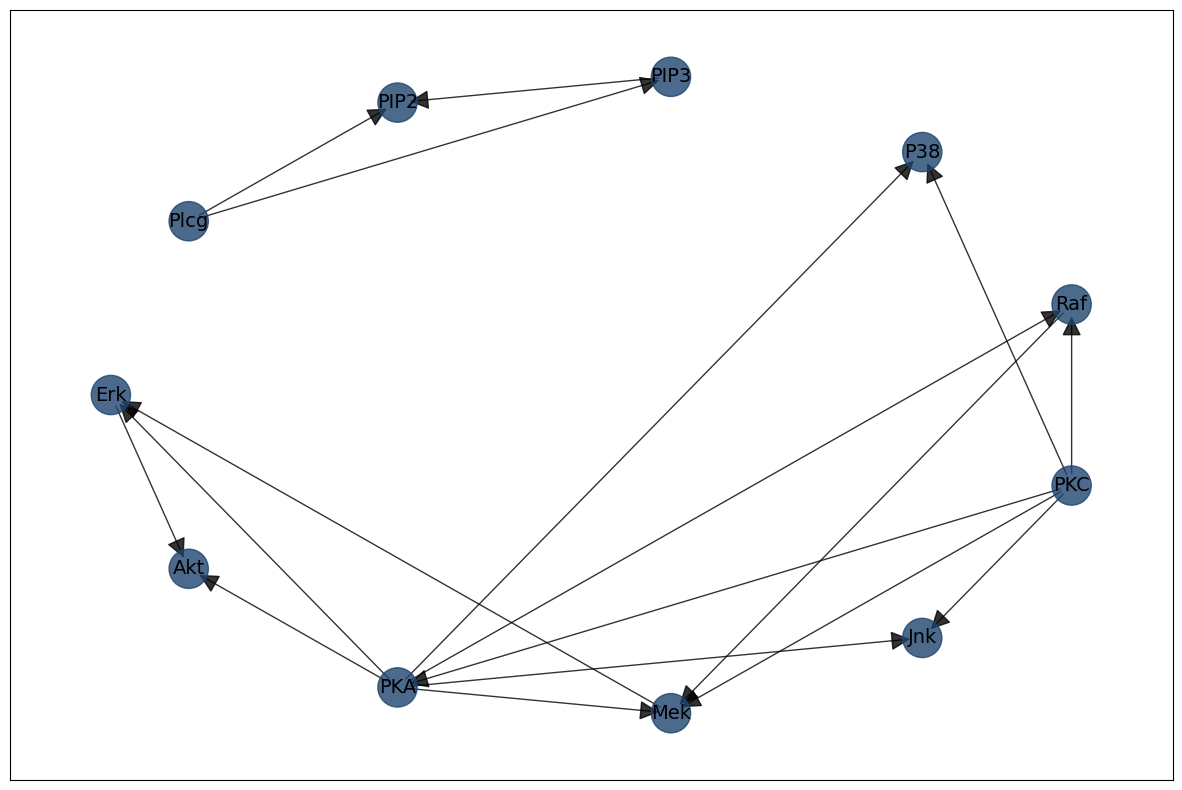

In [9]:
# the ground-truth dag is shown here: XXX: comment in when errors are fixed
ground_truth_dag = bnlearn.import_DAG("sachs", verbose=False)
fig = bnlearn.plot(
    ground_truth_dag,
    params_interactive={"figsize": (5, 4)},
    params_static={"layout": "shell_layout"},
)

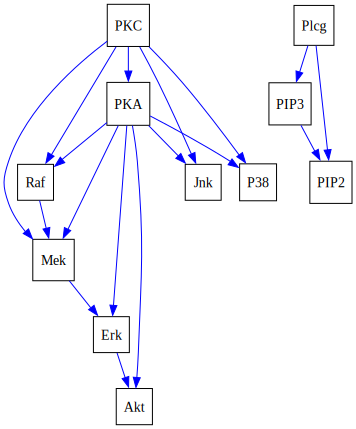

In [10]:
# convert the imported bnlearn graph object into a networkx DiGraph
G = ground_truth_dag["model"].to_directed()

draw(G)

Define the distributions for nodes and functions for edges
----------------------------------------------------------

Now, we can parametrize the graph fully, so that sampling from it is possible.

In [14]:
cardinality_lims = {node: [2, 3] for node in G.nodes}
weight_lims = {node: [1, 2] for node in G.nodes}
noise_ratio_lims = None
seed = 1234

In [15]:
print(cardinality_lims)

{'Erk': [2, 3], 'Akt': [2, 3], 'PKA': [2, 3], 'Mek': [2, 3], 'Jnk': [2, 3], 'PKC': [2, 3], 'Raf': [2, 3], 'P38': [2, 3], 'PIP3': [2, 3], 'PIP2': [2, 3], 'Plcg': [2, 3]}


In [16]:
G = make_random_discrete_graph(
    G,
    cardinality_lims=cardinality_lims,
    weight_lims=weight_lims,
    noise_ratio_lims=noise_ratio_lims,
    random_state=seed,
    overwrite=True,
)

print(G)

DiGraph named 'unknown' with 11 nodes and 17 edges


In [17]:
# we can extract the conditional probability table for each node, which is a function of its parents
node_dict = G.nodes["Mek"]

print(node_dict["cpd"])

+--------+--------------------+-----+--------------------+
| PKA    | PKA(0)             | ... | PKA(1)             |
+--------+--------------------+-----+--------------------+
| PKC    | PKC(0)             | ... | PKC(1)             |
+--------+--------------------+-----+--------------------+
| Raf    | Raf(0)             | ... | Raf(1)             |
+--------+--------------------+-----+--------------------+
| Mek(0) | 0.4083510067110384 | ... | 0.3502136452976631 |
+--------+--------------------+-----+--------------------+
| Mek(1) | 0.5916489932889617 | ... | 0.6497863547023369 |
+--------+--------------------+-----+--------------------+


In [13]:
list(G.predecessors("Erk"))

['PKA', 'Mek']

In [14]:
# now we sample from the graph the discrete dataset
df = sample_from_graph(G, n_samples=100, n_jobs=1, random_state=seed)

In [15]:
print(df.head())

   PKC  Plcg  PKA  PIP3  Jnk  P38  Raf  PIP2  Mek  Erk  Akt
0    2     2    2     1    1    2    2     1    1    2    1
1    1     1    0     0    0    1    0     0    0    0    1
2    2     2    2     1    1    2    2     1    1    2    1
3    1     1    0     0    0    0    0     0    0    0    1
4    1     1    0     0    0    1    0     0    0    0    1


Investigate conditional probability tables
------------------------------------------

Now, each conditional probability table (CPT) follows our specific causal Bayesian network. Given the weights at which we allow uneven sampling, then we can observe conditional independences that will
most likely be present in the data.

In [16]:
# PKC is a node without ancestors, and thus is fully defined by three probability values
node_dict = G.nodes["PKC"]
print(node_dict["cpd"])

+--------+----------+
| PKC(0) | 0.251201 |
+--------+----------+
| PKC(1) | 0.566373 |
+--------+----------+
| PKC(2) | 0.182425 |
+--------+----------+


In [17]:
# PKA is child of node PKC
node_dict = G.nodes["PKA"]
print(node_dict["cpd"])

+--------+---------------------+---------------------+--------------------+
| PKC    | PKC(0)              | PKC(1)              | PKC(2)             |
+--------+---------------------+---------------------+--------------------+
| PKA(0) | 0.23819695847478312 | 0.3888924256398829  | 0.611879115100029  |
+--------+---------------------+---------------------+--------------------+
| PKA(1) | 0.3196799060769118  | 0.30873807550179755 | 0.2137300443256545 |
+--------+---------------------+---------------------+--------------------+
| PKA(2) | 0.44212313544830506 | 0.3023694988583196  | 0.1743908405743165 |
+--------+---------------------+---------------------+--------------------+


In [18]:
# P38 is child of node PKC and PKA, and we see the CPT is defined as a multi-index table
node_dict = G.nodes["P38"]
print_full(node_dict["cpd"])

+--------+---------------------+---------------------+---------------------+--------------------+---------------------+---------------------+--------------------+---------------------+---------------------+
| PKA    | PKA(0)              | PKA(0)              | PKA(0)              | PKA(1)             | PKA(1)              | PKA(1)              | PKA(2)             | PKA(2)              | PKA(2)              |
+--------+---------------------+---------------------+---------------------+--------------------+---------------------+---------------------+--------------------+---------------------+---------------------+
| PKC    | PKC(0)              | PKC(1)              | PKC(2)              | PKC(0)             | PKC(1)              | PKC(2)              | PKC(0)             | PKC(1)              | PKC(2)              |
+--------+---------------------+---------------------+---------------------+--------------------+---------------------+---------------------+--------------------+----------

In [19]:
node_dict = G.nodes["PKA"]
cpt = node_dict["cpd"]
print(cpt.state_names)

{'PKA': [0, 1, 2], 'PKC': [0, 1, 2]}


In [22]:
node_dict = G.nodes["PKA"]
cpt = node_dict["cpd"]

node_dict = G.nodes["PKC"]
cpt_pkc = node_dict["cpd"]

# joint entropy of H(PKA, PKC)
values = cpt.values.flatten()

# Compute the entropy of the joint distribution
joint_entropy = scipy.stats.entropy(values)

# Compute the marginal distributions
marginal_pka = cpt_pkc.marginalize(
    cpt_pkc.variables[1:], inplace=False
).values.flatten()
marginal_pkc = cpt.marginalize(cpt.variables[1:], inplace=False).values.flatten()

# Compute the entropies of variable A and variable B
entropy_pka = scipy.stats.entropy(marginal_pka)
entropy_pkc = scipy.stats.entropy(marginal_pkc)

# Compute the mutual information
mutual_information = entropy_pka + entropy_pkc - joint_entropy

print(entropy_pka, entropy_pkc, joint_entropy)
print("Mutual Information:", mutual_information)

0.9794000630069761 1.0842553783850144 2.1299068687351674
Mutual Information: -0.06625142734317713


In [23]:
print(marginal_pka)
print(marginal_pkc)
print(values)

[0.25120139 0.56637337 0.18242524]
[0.4129895  0.28071601 0.30629449]
[0.23819696 0.38889243 0.61187912 0.31967991 0.30873808 0.21373004
 0.44212314 0.3023695  0.17439084]


Analyze how we might learn the undirected graph
-----------------------------------------------

Given data that is generated with respect to the discrete causal Bayesian network, we can apply common learning algorithms
to learn the graph. For example, if 

In [18]:
from pywhy_graphs.functional.sampling import BayesianSampling

In [19]:
sampler = BayesianSampling(G)

In [20]:
sampler

## Playground

In [66]:
# now we sample from the graph the discrete dataset
df = sample_from_graph(G, n_samples=2000, n_jobs=1, random_state=12345)

In [67]:
ci_estimator = GSquareCITest(data_type="binary")

In [68]:
context = make_context().variables(data=df).build()

pc = PC(ci_estimator=ci_estimator)
pc.fit(df, context)

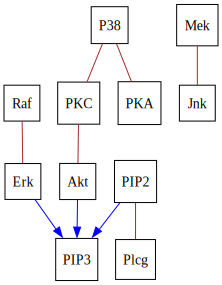

In [69]:
graph = pc.graph_

draw(graph)